# Time-series signatures from raw brdf imagery / smoothed ts outputs

In [1]:
import os
import sys
from pathlib import Path
import rasterio as rio
from rasterio import plot
import matplotlib.pyplot as plt
import shutil
import tempfile
import json
import random
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from pyproj import CRS
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.geometry import Polygon
from rasterio.plot import show
import xarray as xr

%matplotlib inline

In [2]:
sys.path.append(r"../LUCinSA_helpers")
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ts_profile import *

In [3]:
##### Note: 
###  Notebook is housed on login node; time series calculations shold not be run on login node (and take a long time anyway). 
###  Better to install on cluster, run GettimeSeries.sh in Bash folder and copy output file path to parameters 
###  to read with `LoadTSfromFile(TSfile)` to load time series here for plotting.

###TODO: Fix bash script (and LUCinSA_helpers.py) so that it can take more than one cell at a time (cellList should be an array)
###TODO: Enable editing Bash script to run through Slurm via this notebook directly

In [4]:
'''
PARAMETERS: modify in Notebook_settings notebook, then run that notebook and this cell to update here
DO not modify this cell
'''

%store -r basic_config
print("Run Parameters: \n raw_dir = {} \n grid_cell = {} \n index_dir = {} \n grid_file = {} \n out_dir = {}"
      .format(basic_config['raw_dir'],basic_config['grid_cell'],basic_config['index_dir'],basic_config['grid_file'],basic_config['out_dir']))

%store -r timeseries_params
print(" point_file = {}".format(timeseries_params['ptfile']))
if timeseries_params['load_prerunTS'] == True:
    print(" Smooth TS loaded from {}".format(timeseries_params['smooth_TSfile']))
    print(" Raw TS loaded from {}".format(timeseries_params['raw_TSfile']))
    

Run Parameters: 
 raw_dir = /home/sandbox-cel/paraguay_lc/stac/grid 
 grid_cell = 3976 
 index_dir = /home/downspout-cel/paraguay_lc/stac/grids/003976/brdf_ts/ms/gcvi 
 grid_file = /home/sandbox-cel/LUCinLA_grid_8858.gpkg 
 out_dir = /home/klwalker/data/tmp
 point_file = /home/klwalker/data/tmp/SelectedCoords.csv


In [ ]:
natpts = get_pts_in_grid(basic_config['grid_file'], basic_config['grid_cell'], timeseries_params['ptfile'])
natpts.head(n=5)

## Plot smooth time series

In [ ]:
if timeseries_params['load_prerunTS'] == True:
    if timeseries_params['smooth_TSfile']:
        smooth = load_ts_from_file(timeseries_params['smooth_TSfile'])
else:
    smooth = get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['smooth_dir'], 'Smooth', basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=timeseries_params['load_samp'], ptfile=timeseries_params['ptfile'])

In [ ]:
smooth = smooth[smooth['ALL'] != 0]

fig = plt.figure(figsize=(10, 5))
plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
#plt.errorbar(raw.index, raw['ALL'], yerr=raw['stdv'], fmt='o', color='g')
plt.title('Smoothed {} for sample {}-{}'.format(basic_config['spec_index'],timeseries_params['start_yr'],timeseries_params['end_yr']))
plt.ylim(0,7000)
plt.show();

## To compare two smoothed time-series (i.e. with different parameters)
One is in the regular time_series folder called 'brdf_ts/ms/index' and the other is in folder called 'brdf_ts_old/ms/index'  

In [ ]:
if not os.path.exists(os.path.join(basic_config['smooth_dir'],'{:06d}'.format(basic_config['grid_cell']),'brdf_ts_old','ms',basic_config['spec_index'])):
    print('There is no old time series to compare')
else:
    old = get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['smooth_dir'], 'Smooth_old', basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=timeseries_params['load_samp'], ptfile=timeseries_params['ptfile'])

    old = old[old['ALL'] != 0]

    fig = plt.figure(figsize=(10, 5))
    plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
    plt.errorbar(old.index, old['ALL'], yerr=old['stdv'], fmt='o', color='g')
    plt.title('New vs old smoothed ts {} for sample {}-{}'.format(basic_config['spec_index'],timeseries_params['start_yr'],timeseries_params['end_yr']))
    plt.ylim(0,7000)
    plt.show();

## Plot raw time series

In [ ]:
if timeseries_params['load_prerunTS'] == True:
    if timeseries_params['raw_TSfile']:
        raw = load_TSfromFile(timeseries_params['raw_TSfile'])
else:
    raw = get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['raw_dir'], timeseries_params['image_type'], basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=timeseries_params['load_samp'], ptfile=timeseries_params['ptfile'])

In [ ]:
raw = raw[raw['ALL'] != 0]

fig = plt.figure(figsize=(10, 5))
#plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
plt.errorbar(raw.index, raw['ALL'], yerr=raw['stdv'], fmt='o', color='g')
plt.title('Raw {} for sample points {}-{}'.format(basic_config['spec_index'], timeseries_params['start_yr'],timeseries_params['end_yr']))
plt.show()

## To plot a timeseries for each polygon in file:

In [5]:
smooth = get_timeseries_for_pts_multicell(basic_config['out_dir'], basic_config['spec_index'], timeseries_params['start_yr'], timeseries_params['end_yr'],
            basic_config['smooth_dir'], 'Smooth', basic_config['grid_file'], timeseries_params['grid_cells'], 
            ground_polys=timeseries_params['ground_polys'], oldest=timeseries_params['oldest_samp'], newest=timeseries_params['newest_samp'],
            npts=timeseries_params['npts'], seed=timeseries_params['seed1'], load_samp=timeseries_params['load_samp'], ptfile=timeseries_params['ptfile'])

working on cell 3842
Of the 28 polygons, 2 are in grid_cell 3842
getting index values...
                              geometry  2020153  2020162  2020172  2020183  \
11_1  POINT (3073971.335 -3313792.112)      NaN      NaN      NaN      NaN   
11_2  POINT (3073969.121 -3313787.775)      NaN      NaN      NaN      NaN   
11_3  POINT (3073969.706 -3313790.069)      NaN      NaN      NaN      NaN   
11_4  POINT (3073970.593 -3313798.758)      NaN      NaN      NaN      NaN   
11_5  POINT (3073966.135 -3313793.458)      NaN      NaN      NaN      NaN   
12_1  POINT (3076981.788 -3313936.527)      NaN      NaN      NaN      NaN   
12_2  POINT (3076968.063 -3313940.056)      NaN      NaN      NaN      NaN   
12_3  POINT (3076980.077 -3313967.907)      NaN      NaN      NaN      NaN   
12_4  POINT (3076959.482 -3313953.970)      NaN      NaN      NaN      NaN   
12_5  POINT (3076994.507 -3313928.642)      NaN      NaN      NaN      NaN   
0                                 None   5128.0   502

Of the 28 polygons, 0 are in grid_cell 3880
skipping this cell
working on cell 3911
Of the 28 polygons, 0 are in grid_cell 3911
skipping this cell
working on cell 3912
Of the 28 polygons, 7 are in grid_cell 3912
getting index values...
                             geometry  2020153  2020162  2020172  2020183  \
2_1  POINT (3105738.048 -3291870.103)      NaN      NaN      NaN      NaN   
2_2  POINT (3105689.427 -3291863.273)      NaN      NaN      NaN      NaN   
2_3  POINT (3105700.621 -3291920.116)      NaN      NaN      NaN      NaN   
2_4  POINT (3105755.901 -3291892.464)      NaN      NaN      NaN      NaN   
2_5  POINT (3105740.643 -3291863.982)      NaN      NaN      NaN      NaN   
..                                ...      ...      ...      ...      ...   
30                               None   4389.0   4240.0   4579.0   4901.0   
31                               None   3800.0   3773.0   4050.0   4350.0   
32                               None   3800.0   3773.0   4050.0   4350

Of the 28 polygons, 5 are in grid_cell 3947
getting index values...
                              geometry  2020153  2020162  2020172  2020183  \
7_1   POINT (3120115.104 -3301773.271)      NaN      NaN      NaN      NaN   
7_2   POINT (3120178.547 -3301867.588)      NaN      NaN      NaN      NaN   
7_3   POINT (3120189.166 -3301834.360)      NaN      NaN      NaN      NaN   
7_4   POINT (3120178.280 -3301814.961)      NaN      NaN      NaN      NaN   
7_5   POINT (3120117.727 -3301815.867)      NaN      NaN      NaN      NaN   
8_1   POINT (3120122.585 -3301624.492)      NaN      NaN      NaN      NaN   
8_2   POINT (3120148.524 -3301645.213)      NaN      NaN      NaN      NaN   
8_3   POINT (3120149.130 -3301648.684)      NaN      NaN      NaN      NaN   
8_4   POINT (3120124.802 -3301679.345)      NaN      NaN      NaN      NaN   
8_5   POINT (3120119.727 -3301645.852)      NaN      NaN      NaN      NaN   
23_1  POINT (3125586.590 -3303252.227)      NaN      NaN      NaN      NaN

Of the 28 polygons, 0 are in grid_cell 3948
skipping this cell
working on cell 3976
Of the 28 polygons, 0 are in grid_cell 3976
skipping this cell
working on cell 3978
Of the 28 polygons, 0 are in grid_cell 3978
skipping this cell
working on cell 3979
Of the 28 polygons, 0 are in grid_cell 3979
skipping this cell
working on cell 3980
Of the 28 polygons, 0 are in grid_cell 3980
skipping this cell
working on cell 4007
Of the 28 polygons, 0 are in grid_cell 4007
skipping this cell
working on cell 4008
Of the 28 polygons, 0 are in grid_cell 4008
skipping this cell
working on cell 4009
Of the 28 polygons, 0 are in grid_cell 4009
skipping this cell
working on cell 4010
Of the 28 polygons, 0 are in grid_cell 4010
skipping this cell
working on cell 4036
Of the 28 polygons, 0 are in grid_cell 4036
skipping this cell


In [16]:
smooth

,11_1,11_2,11_3,11_4,11_5,12_1,12_2,12_3,12_4,12_5,...,17,18,19,20,21,22,23,24,ALL,stdv
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3950.0,5048.0,5704.0,4128.0,4392.0,4271.0,4326.0,4626.0,4563.553846,964.026444
2020-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3768.0,5067.0,5458.0,3860.0,4174.0,4213.0,4295.0,4573.0,4385.976923,918.952367
2020-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3560.0,5163.0,5066.0,3575.0,4011.0,4245.0,4337.0,4663.0,4408.253846,932.840982
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3450.0,5118.0,4958.0,3501.0,4046.0,4353.0,4429.0,4750.0,4554.869231,990.784851
2020-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3578.0,4501.0,5000.0,3386.0,3636.0,4081.0,4035.0,4361.0,4253.230769,928.451735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5270.0,5934.0,4556.0,4933.0,4948.0,5340.0,5558.0,5226.0,5107.607692,943.553190
2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5200.0,5968.0,4639.0,4868.0,5132.0,5457.0,5652.0,5406.0,5129.907692,990.497843
2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5020.0,5579.0,4799.0,4334.0,4438.0,5374.0,5406.0,5357.0,5067.307692,1003.994988


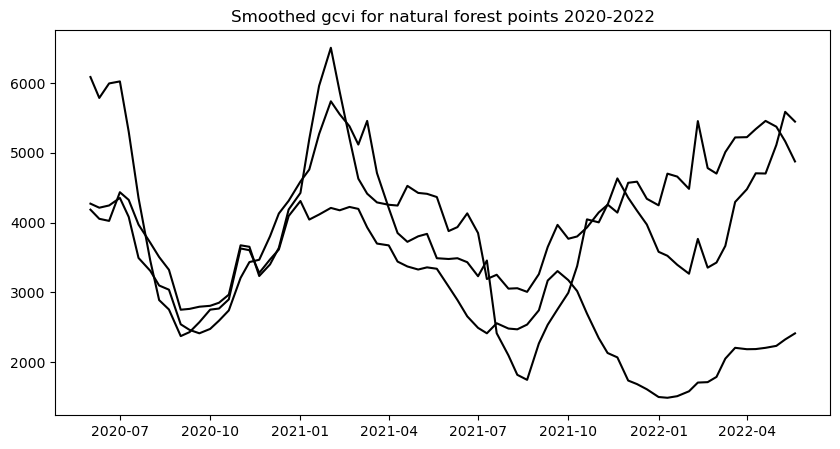

In [19]:
smooth = smooth[smooth['ALL'] != 0]

fig = plt.figure(figsize=(10, 5))
#plt.errorbar(smooth.index, smooth['ALL'], yerr=smooth['stdv'], fmt='o', color='k')
plt.plot(smooth.index, smooth[22], color='k')
#plt.errorbar(raw.index, raw['ALL'], yerr=raw['stdv'], fmt='o', color='g')
plt.title('Smoothed {} for natural forest points {}-{}'.format(basic_config['spec_index'],timeseries_params['start_yr'],timeseries_params['end_yr']))
plt.show();

## To save an html copy of this notebook with all outputs:

In [ ]:
### Run to print output as html

out_name = str(basic_config['country']+'2_TimeSeries'+str(basic_config['grid_cell'])+'_from_'+str(timeseries_params['start_yr'])+'_to_'+str(timeseries_params['end_yr']))
!jupyter nbconvert --output-dir='../outputs' --to html --no-input --output=$out_name 2_TimeSeriesSignatures.ipynb